# UMAP Panel and Views

Here the use of the UMAP panel interface.

***Setting up the notebook***

In [ ]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import upsetplot
import itertools

import GSForge as gsf

import holoviews as hv
# hv.extension("bokeh")
hv.extension("matplotlib")

***Declare paths used***

In [2]:
# OS-independent path management.
from os import fspath, environ
from pathlib import Path

In [3]:
OSF_PATH = Path(environ.get("GSFORGE_DEMO_DATA", default="~/GSForge_demo_data/osfstorage")).expanduser()
HYDRO_NORMED_GEM_PATH = OSF_PATH.joinpath("AnnotatedGEMs", "oryza_sativa_hydro_normed.nc")
LIT_DGE_GSC_PATH = OSF_PATH.joinpath("Collections", "literature", "DGE")
LIT_TF_PATH = OSF_PATH.joinpath("Collections", "literature", "TF")
BORUTA_GSC_PATH = OSF_PATH.joinpath("Collections", "nf_boruta")
assert HYDRO_NORMED_GEM_PATH.exists()

***Load an AnnotatedGEM***

In [4]:
agem = gsf.AnnotatedGEM(HYDRO_NORMED_GEM_PATH)
agem

<GSForge.AnnotatedGEM>
Name: Oryza Sativa
Selected GEM Variable: 'counts'
    Gene   66338
    Sample 475

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)
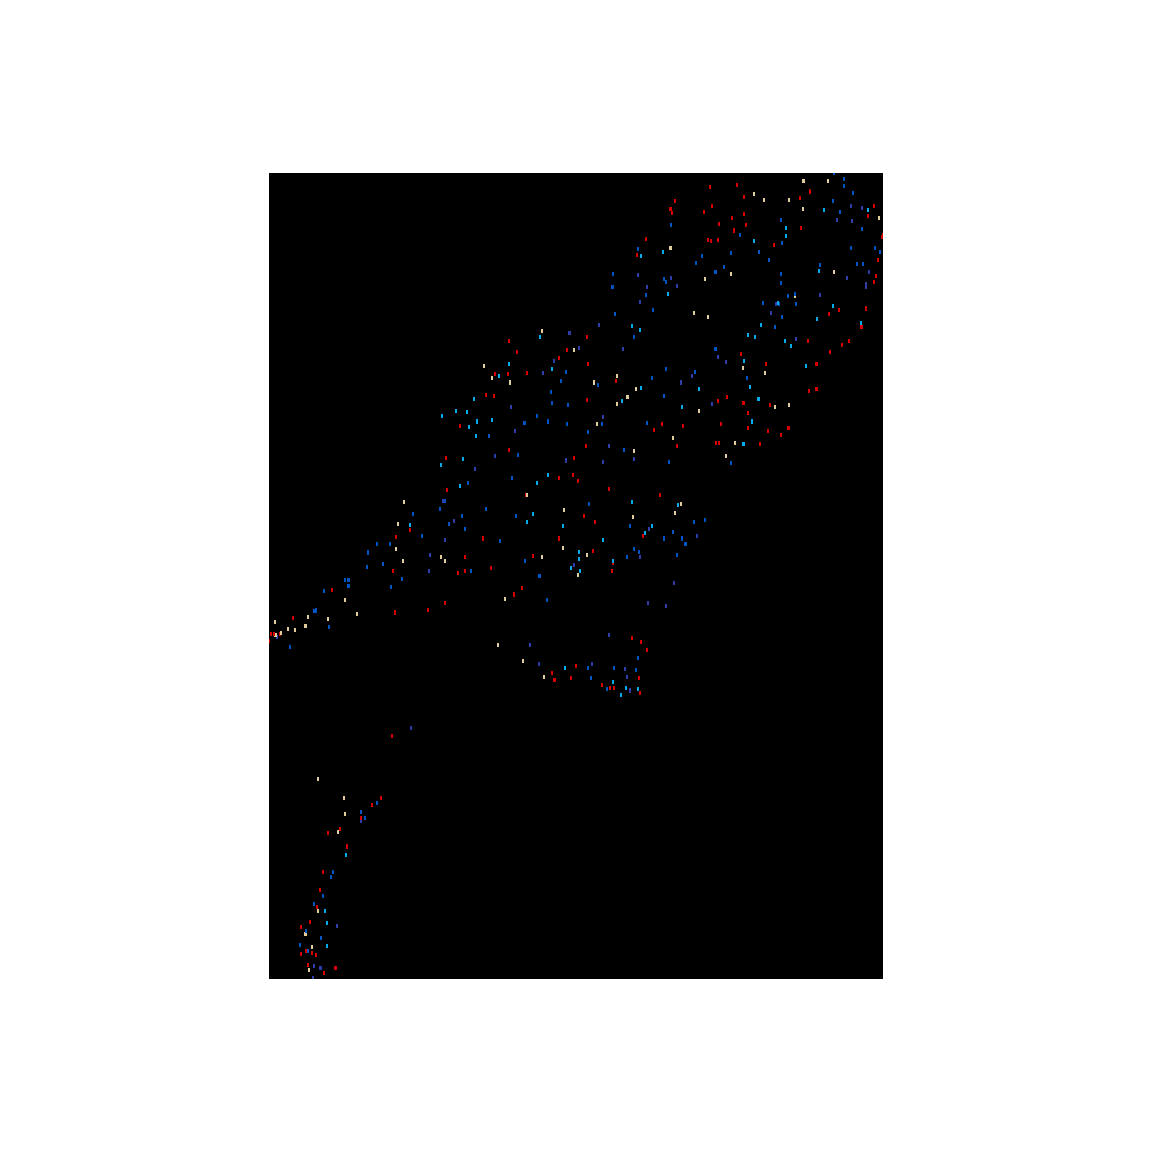

In [5]:
datashade_kwargs = dict(width=900, height=600)

umap_panel = gsf.panels.UMAP_Interface(agem, random_state=42,
                                       datashade=True, 
                                       dynspread=True,
                                       datashade_kwargs=datashade_kwargs)

plot = umap_panel.view(hue='treatment', n_neighbors=200)
plot

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)
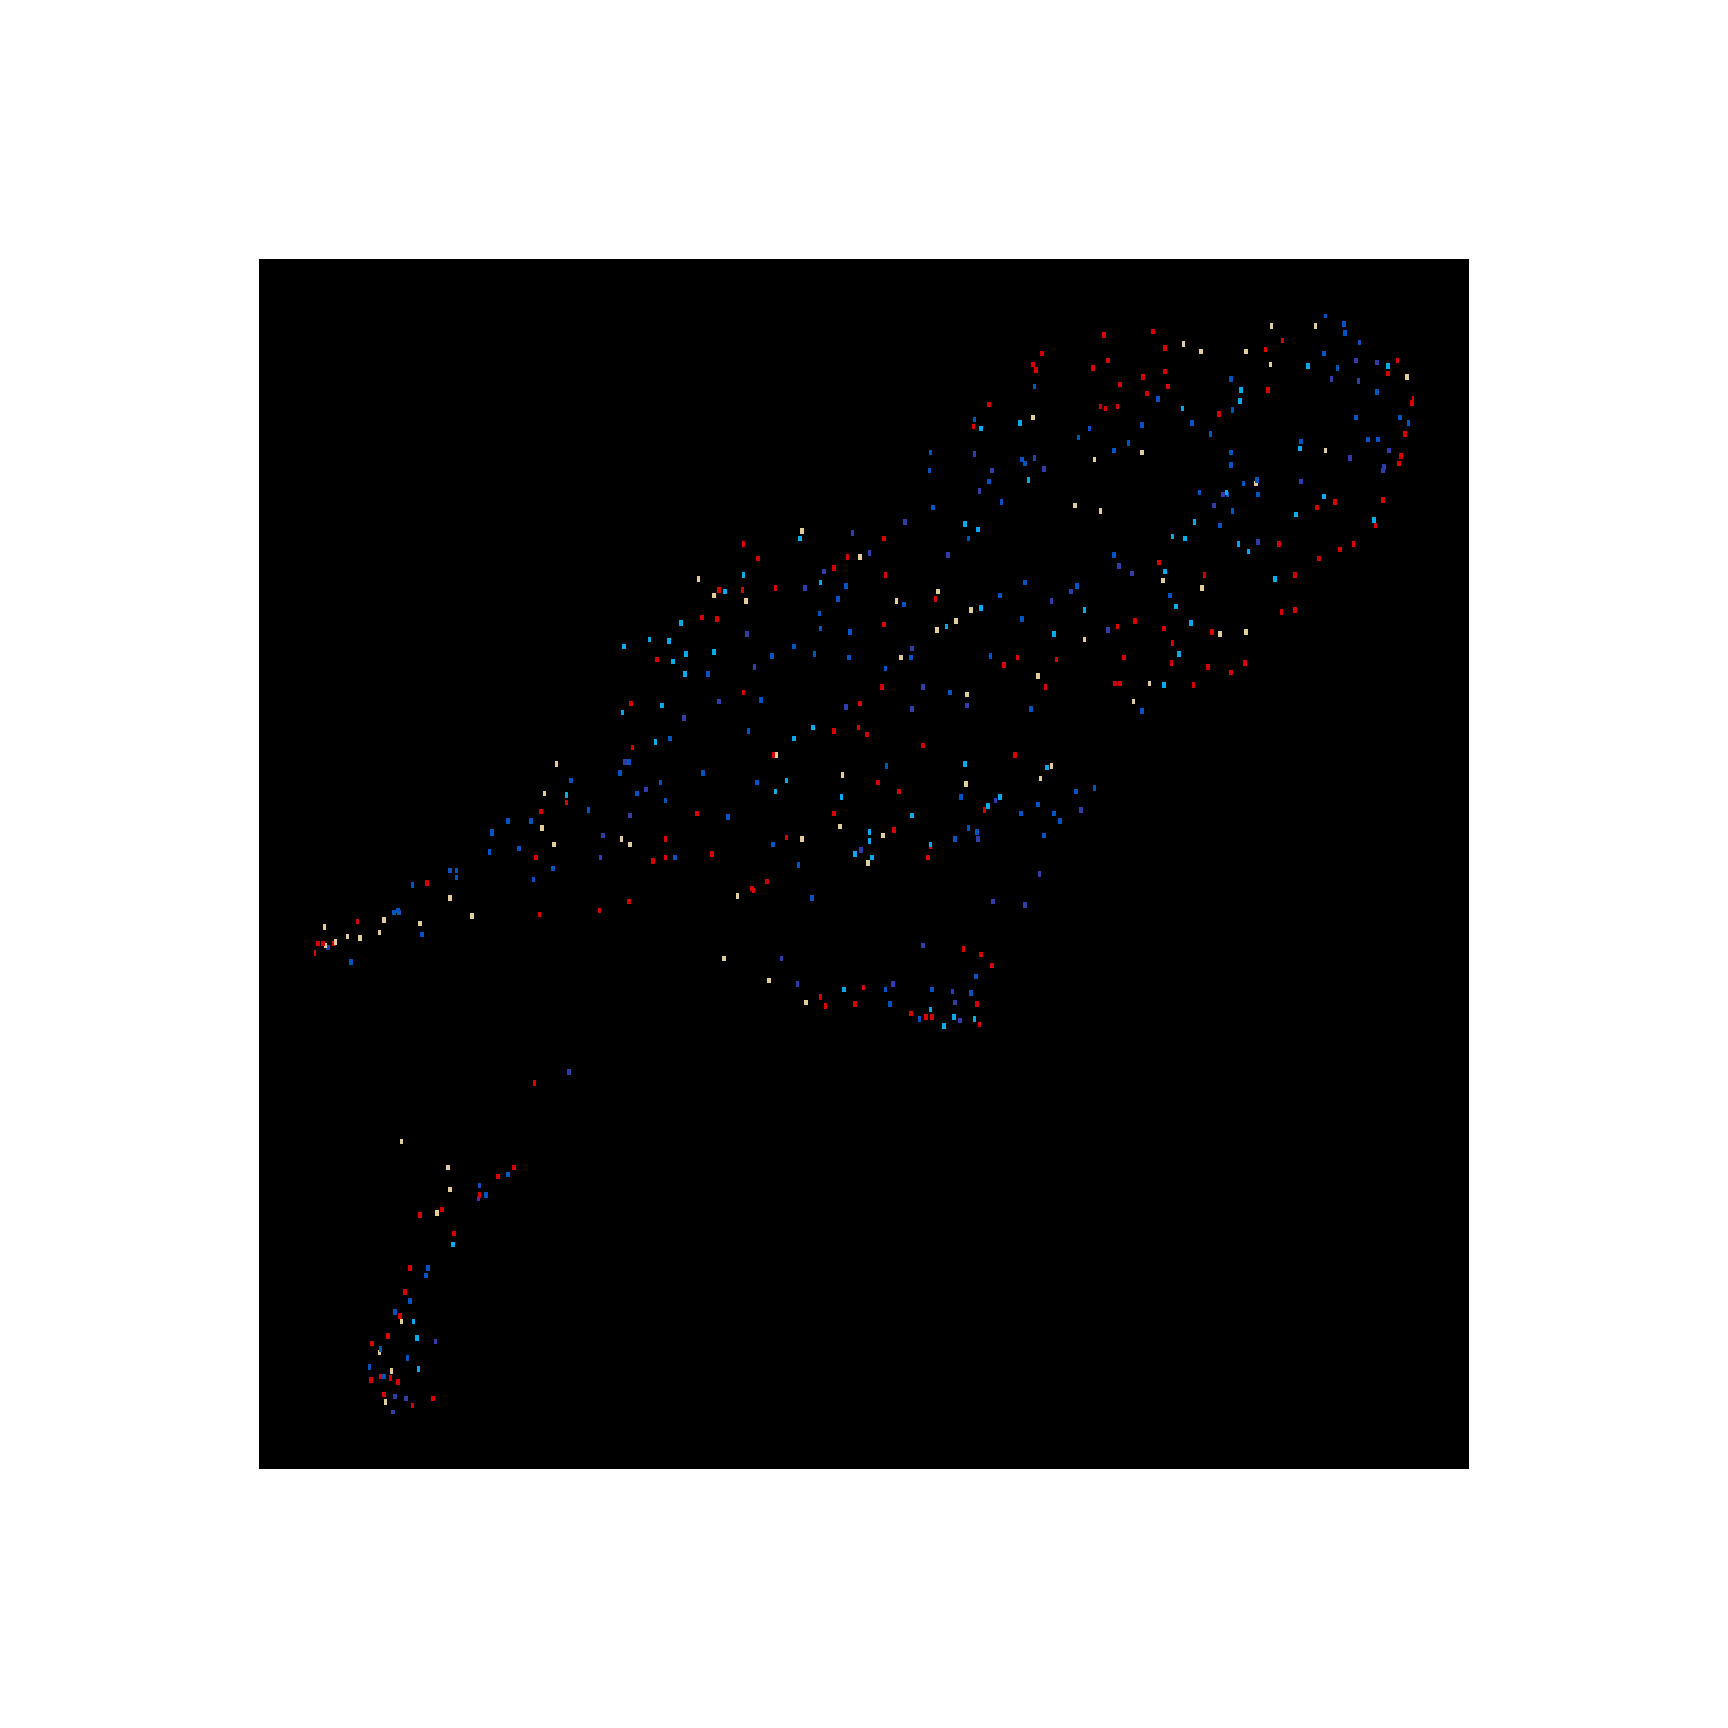

In [19]:
plot.opts(hv.opts.RGB(aspect=1, fig_inches=12, padding=0.05))

In [5]:
agem.count_array_names[:-1]

['counts', 'TPM_counts', 'uq_raw_counts', 'uq_tpm_counts', 'tmm_counts']

***Load GeneSetCollections***

In [6]:
%%time
lit_dge_coll = gsf.GeneSetCollection.from_folder(gem=agem, target_dir=LIT_DGE_GSC_PATH, name="Literature DGE")
lit_tf_coll = gsf.GeneSetCollection.from_folder(gem=agem, target_dir=LIT_TF_PATH, name="Literature TF")
boruta_gsc = gsf.GeneSetCollection.from_folder(gem=agem, target_dir=BORUTA_GSC_PATH, name="Boruta Results")
tf_geneset = gsf.GeneSet.from_GeneSets(*list(lit_tf_coll.gene_sets.values()), name='transcription factors')
combined_gsc = gsf.GeneSetCollection(gem=agem, gene_sets={**boruta_gsc.gene_sets, 
                                                          **lit_dge_coll.gene_sets,
                                                          'transcription factors': tf_geneset})

CPU times: user 25.6 s, sys: 280 ms, total: 25.9 s
Wall time: 25.9 s


In [7]:
combined_gsc

<GSForge.GeneSetCollection>
GeneSetCollection01523
GeneSets (11 total): Support Count
    DROUGHT_UP: 1175
    treatment: 1155
    genotype: 853
    HEAT_UP: 592
    RECOV_DROUGHT_UP: 446
    ... and 6 more.

## Create and Explore the Panel

Setting the random state to some value is important for reproducibility. You should not pick an especially 'unique' random state -- you should instead notice rotations of the same basic layout.

In [8]:
umap_panel = gsf.panels.UMAP_Interface(combined_gsc, random_state=400, n_neighbors=421)
# umap_panel.panel()

## Generate and Save Views

Often times I explore settings using the application above, then write script to generaet the plots I am interested in quickly.

In [15]:
sets_of_interest = {
    'all_genes': [None],
    'all_selections': list(combined_gsc.gene_sets.keys()),
    'all_sans_genotype': [x for x in list(combined_gsc.gene_sets.keys()) if x != 'Boruta_genotype'],
    'lit_dge': list(lit_dge_coll.gene_sets.keys()),
    'lit_tf': ['transcription factors'],
    'boruta': list(boruta_gsc.gene_sets.keys()),
    'boruta_treatment': ['treatment'],
    'treatment_sel': ['treatment'] + list(lit_dge_coll.gene_sets.keys()),
}

In [16]:
list(sets_of_interest.keys())

['all_genes',
 'all_selections',
 'all_sans_genotype',
 'lit_dge',
 'lit_tf',
 'boruta',
 'boruta_treatment',
 'treatment_sel']

And we are surely interested in viewing the colors mapped to treatment and genotype.

In [13]:
hues = ['treatment', 'genotype']
n_neighbors = [15, 50, 200, 325, 474]
count_vars = agem.count_array_names[:-1]

In [14]:
for hue, (key, gene_selection), nn, count_var in itertools.product(
    hues, 
    sets_of_interest.items(), 
    n_neighbors,
    count_vars):
    plot = umap_panel.view(gene_set_mode='union', 
                           count_variable=count_var, 
                           n_neighbors=nn,
                           selected_gene_sets=gene_selection, 
                           hue=hue).opts(show_legend=False,
        width=600, height=600)
    hv.save(plot, f'figures/umaps/UMAP_{key}_of_{count_var}_hue_{hue}.png', dpi=300, toolbar=None)

In [ ]:
# %load_ext watermark
# %watermark -v -p numpy,scipy,pandas,bokeh,holoviews,datashader,jupyterlab